In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from file_tools import experiment as et
from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from basic_viewing import kwik_functions as kwkf
from basic_viewing import h5_functions as kwdf
from h5tools import h5tools as h5
from streamtools import streams as st
from streamtools import spectral as sp
from streamtools import temporal as tp


Computer: passaro


In [2]:
# bird and session

bird = 'z023'
sess = 'day-anesth_surface_2016-11-14_6'
stim_sess = '001'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

In [3]:
exp_par['search_motiff']

{'corr_thresh': 0.85,
 'filt_hi': 400,
 'filt_lo': 10000,
 'motiff_patterns': {'bos_rev_tag': 'bos_rev_tag.wav',
  'bos_tag': 'bos_tag.wav'},
 'n_overlap': 192,
 'n_window': 256,
 'onset_resolution': 1,
 'rms_threshold': 2.0,
 'rolling_method': 'pandas',
 'sigma_factor': 0.001,
 'window_env': 500}

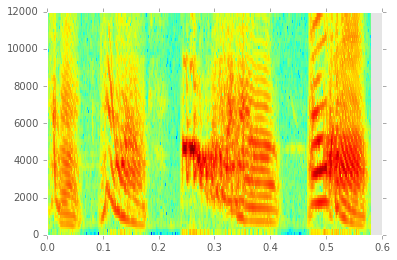

In [5]:
#pattern
m_name = 'bos_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

n_window = 192
n_overlap = 191
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

In [47]:
pattern_spectrogram[2].shape

(97, 17307)

In [6]:
class H5Data:
    def __init__(self, h5_table, s_f, dtype=None):
        self.data_type = np.dtype(h5_table.dtype) if dtype is None else dtype
        self.s_f = s_f
        self.n_chans = h5_table.shape[h5_table.ndim-1]
        self.n_samples = int(h5_table.size/h5_table.shape[h5_table.ndim-1])
        self.table = h5_table

    def get_chunk(self, start, end, chan_list=[0]):
        assert (start >= 0)
        assert (end <= self.n_samples)
        assert (end > start)

        data = np.array(h5.load_table_slice(self.table, np.arange(start, end), chan_list),
                        dtype=self.data_type)
        return data



(<matplotlib.figure.Figure at 0x7f9abe428690>,
 <matplotlib.axes._axes.Axes at 0x7f9abe378c50>)

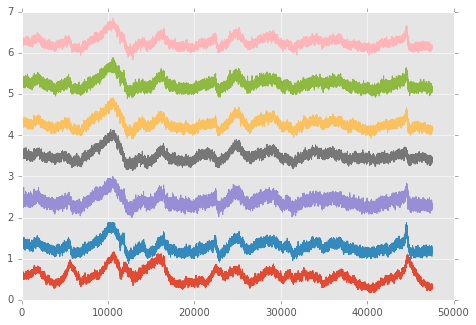

In [37]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 5
neural_chans = np.array(exp_par['channel_config']['neural'][:])
before = 15000
after = 15000
#neural_chans = np.array([32, 33, 34])
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

# bad_chans = np.array([0, 25, 31])
# neural_chans = np.delete(neural_chans, bad_chans)
good_chans = np.array([1, 11, 12, 13, 14, 15, 16])

neural_chans = neural_chans[good_chans]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.plot()

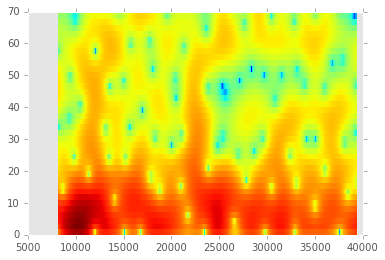

In [38]:
f_cut = 70
n_window = 2048*8
n_overlap = n_window-8

response_spectrogram = spectrogram(lfp_frame.data[:, 6], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*30), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [22]:
response_spectrogram = spectrogram(lfp_frame.data[:, 15], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

IndexError: index 15 is out of bounds for axis 1 with size 8

In [26]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


spectr_stack = []

for ch in range(n_chans):
    print ch
    for i_trial in range(n_trials):
        start = starts[i_trial]
        one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
        lfp[:, i_trial, :] = one_frame.data
        this_spectrogram = spectrogram(one_frame.data[:, ch], s_f, 
                                      nperseg = n_window, 
                                      noverlap= n_overlap, 
                                      window = sg.gaussian(n_window, sigma*50), 
                                      scaling='density')
        spectr[i_trial, :, :] = (this_spectrogram[2])
    
    spectr_stack.append(spectr)
    
#all_spectra = np.stack(spectr_stack, axis=0)

0
1
2
3
4
5
6
7


MemoryError: 

In [66]:
all_spectra = np.stack(spectr_stack, axis=0)

MemoryError: 

In [52]:
spectr_stack[0].shape

(74, 8193, 3890)

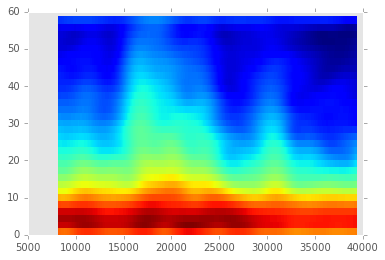

In [28]:
f_cut = 60
ch = 2
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

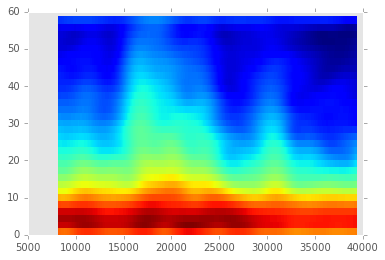

In [34]:
f_cut = 60
ch = 4
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

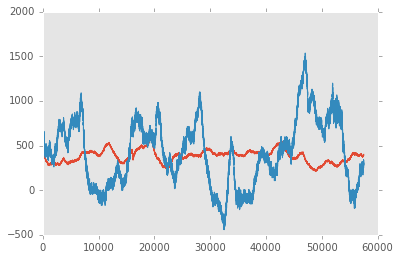

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

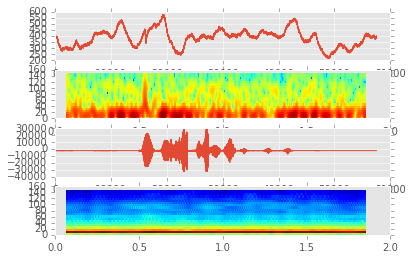

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


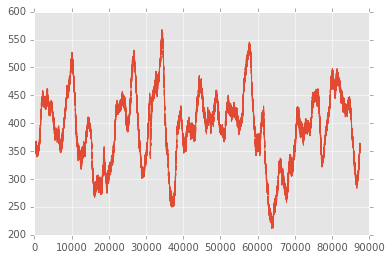

In [96]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))

In [24]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec][:-1]):
        print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


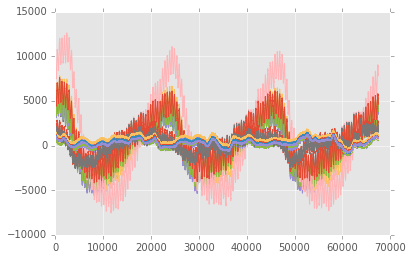

In [10]:
plt.plot(sup_lfp[:,7,:].T)

In [37]:
np.unique(recs)

array([0])

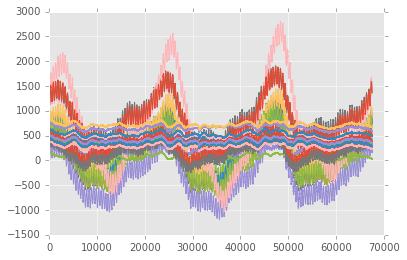

In [11]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape
plt.plot(trial_mean.T)

In [15]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape

(31, 67535)

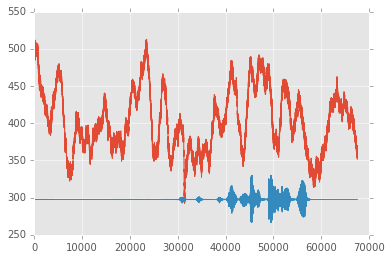

In [38]:
plt.plot(trial_mean[30,:])
plt.plot(lfp_frame.data[:,31]/1000. + 300)

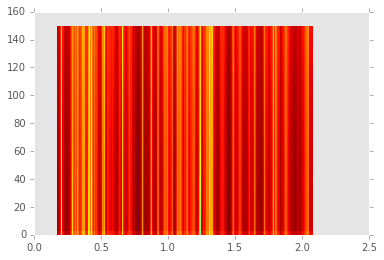

In [46]:
f_cut = 150
n_window = 1024*10
n_overlap = n_window - 1
response_spectrogram = spectrogram(trial_mean[30,:], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [ ]:
scipy.io.wavfile.write(filename, rate, data)

In [49]:
wavfile.write('one_channel.wav', 30000, trial_mean[30,:].astype(np.int16))


In [48]:
pwd

u'/mnt/cube/earneodo/repos/ephysflow'